In [98]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
import statsmodels.api as sm

import sys
sys.path.append("../")

from src import modelers

plt.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Prediction algorithms (supervised learning)
1. Linear Regression
2. Random Forest Regression

In [99]:
# Import data
pd.set_option("display.max_columns", 40)
data = pd.read_csv('../data/cleaned_data2.csv')
data.head()

,Unnamed: 0,state,county,fips,white_pct,black_pct,hispanic_pct,foreignborn_pct,female_pct,age29andunder_pct,age65andolder_pct,median_hh_inc,clf_unemploy_pct,lesshs_pct,lesscollege_pct,rural_pct,trump16_pct,clinton16_pct,otherpres16_pct,romney12_pct,obama12_pct,otherpres12_pct,cvap_pct12,metro,rural,urban_metroadj,urban_not_metroadj
0,0,Alabama,Autauga,1001,75.683482,18.370906,2.572254,1.838362,51.176225,40.037058,13.978456,53099.0,5.591657,12.417046,75.407229,42.002162,72.766588,23.769671,3.463741,72.618252,26.587832,0.793916,58.815434,1,0,0,0
1,1,Alabama,Baldwin,1003,83.178788,9.225603,4.366698,3.269510,51.194928,35.474412,18.714851,51365.0,6.286843,9.972418,70.452889,42.279099,76.545712,19.385601,4.068687,77.358269,21.589444,1.052286,56.228504,1,0,0,0
2,2,Alabama,Barbour,1005,45.885624,47.888329,4.309762,2.859397,46.498084,37.664387,16.528895,33956.0,12.824738,26.235928,87.132213,67.789635,52.096666,46.527844,1.375490,48.223130,51.368494,0.408376,56.485890,0,0,1,0
3,3,Alabama,Bibb,1007,74.765196,21.212121,2.223994,1.351232,46.464646,37.329435,14.885699,39776.0,7.146827,19.301587,88.000000,68.352607,76.403220,21.249575,2.347205,72.826603,26.152019,1.021378,47.868107,1,0,0,0
4,4,Alabama,Blount,1009,87.657701,1.557951,8.727298,4.271801,50.485235,37.240053,17.192916,46212.0,5.953833,19.968585,86.950243,89.951502,89.334844,8.425825,2.239331,86.465884,12.371907,1.162209,56.577893,1,0,0,0


In [100]:
# Extract our labels
trump = data.pop('trump16_pct')
clinton = data.pop('clinton16_pct')
other = data.pop('otherpres16_pct')

# Drop columns that we think are too correlated with one another
data = data.drop(columns=['Unnamed: 0', 'state', 'county', 'fips', 
                           'otherpres12_pct', 'black_pct', 'hispanic_pct'])
data2 = data.drop(columns=['obama12_pct'])
data3 = data2.drop(columns=['metro', 'rural', 'urban_metroadj', 'urban_not_metroadj', 'romney12_pct'])

In [101]:
len(data3.columns)

11

In [102]:
# Make our X and y and do 75%/25% split
X = data3
y = trump

X_train, X_test, y_train, y_test = train_test_split(X, y)
X_trainn, X_testn = modelers.normalize(X_train, X_test)
rmse, r_sq, y_hat, model_coeff = modelers.lin_regression(X_trainn, X_testn, y_train, y_test)

# Keep track of indices
train_idx = X_train.index.values
test_idx = X_test.index.values

## Test toy model before using Kfold

In [103]:
rmse, r_sq, model_coeff

(9.530437864655484,
 0.6617084716875813,
 array([ 37.53751467,  -5.97166802,   2.00615051,  25.90428882,
         32.38862634,  29.18860141, -30.75307219,  23.28133542,
         48.58242393,   8.35518405, -36.7130795 ]))

In [104]:
# Get p-values by using stats models 
model = sm.OLS(y_train, X_trainn).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:            trump16_pct   R-squared (uncentered):                   0.979
Model:                            OLS   Adj. R-squared (uncentered):              0.979
Method:                 Least Squares   F-statistic:                              9722.
Date:                Fri, 15 May 2020   Prob (F-statistic):                        0.00
Time:                        15:49:21   Log-Likelihood:                         -8560.6
No. Observations:                2333   AIC:                                  1.714e+04
Df Residuals:                    2322   BIC:                                  1.721e+04
Df Model:                          11                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            35.3614      1.484     23.834      0.000      32.452      38.271
x2            -7.6830      2.891     -2.657      0.008     -13.352      -2.014
x3            -2.4610      3.285     -0.749      0.454      -8.903       3.981
x4            14.3801      3.336      4.311      0.000       7.839      20.921
x5            23.0554      3.968      5.811      0.000      15.275      30.836
x6            22.7262      2.672      8.507      0.000      17.487      27.965
x7           -33.6348      2.279    -14.756      0.000     -38.105     -29.165
x8            21.5338      2.857      7.538      0.000      15.932      27.136
x9            42.8665      2.455     17.460      0.000      38.052      47.681
x10            8.4348      0.927      9.098      0.000       6.617      10.253
x11          -40.5610      3.013    -13.461      0.000     -46.470     -34.652
==============================================================================
Omnibus:                       14.196   Durbin-Watson:                   1.947
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.260
Skew:                          -0.148   Prob(JB):                     0.000486
Kurtosis:                       3.262   Cond. No.                         46.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [105]:
# Keep track of RMSE and R_sq
d = {}

## KFold with linear regression

In [106]:
fold_scores, r_sq, coeffs = modelers.kfold_scores(X_trainn, y_train, modelers.lin_regression, 5)
fold_scores, fold_scores.mean(), r_sq, r_sq.mean()

(array([9.27369822, 9.82448677, 9.14532619, 9.54082492, 9.84572365]),
 9.526011951233892,
 array([0.61446041, 0.61804158, 0.66256832, 0.57401608, 0.61926642]),
 0.6176705602858424)

In [59]:
d['Linear Regression'] = [fold_scores, r_sq]

In [108]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["beta"])
coeff

# Add to df
coeff['p-values'] = model.pvalues.values
coeff = coeff.apply(lambda x: round(x,2))
coeff.sort_values(by='p-values')

# Plot these to look nice
coeff.sort_values(by='p-values')['p-values'].plot(kind='barh')
plt.title("P-values")
plt.savefig('../images/pvalues-data4.png', bbox_inches='tight', dpi=250)

coeff.sort_values(by='beta')['beta'].plot(kind='barh')
plt.title("Beta Coefficients")
plt.savefig('../images/betas_data4.png', bbox_inches='tight', dpi=250)

NameError: name 'data4' is not defined

## Save predictions

In [47]:
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions.csv')

## Random Forest Regressor

In [109]:
# Get model predictions
rmse, r_sq, y_hat, coeff = modelers.random_forest(X_trainn, X_testn, y_train, y_test)

In [110]:
r_sq

0.7434720305801195

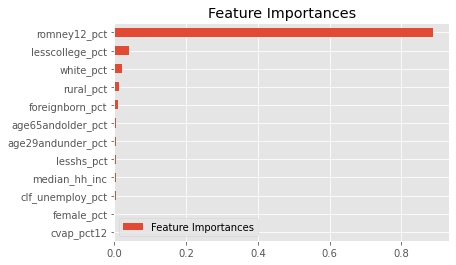

In [46]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["Feature Importances"])

# Plot these to look nice
coeff.sort_values(by='Feature Importances').plot(kind='barh')
plt.title("Feature Importances")
plt.savefig('../images/featureimportRF-data3.png', bbox_inches='tight', dpi=250)

In [111]:
# Check model
rmse, r_sq, coeff = modelers.kfold_scores(X_trainn, y_train, modelers.random_forest, 5)
rmse, r_sq, rmse.mean(), r_sq.mean()

(array([7.76761709, 8.07268345, 7.70780706, 8.29466   , 7.99912176]),
 array([0.76460919, 0.69323136, 0.77522086, 0.69615551, 0.71707683]),
 7.968377871496637,
 0.7292587491413186)

In [63]:
d['Random Forest'] = [rmse, r_sq]

In [38]:
# Save predictions
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions_RF.csv')

## Gradient Boosting Regressor

In [55]:
# Get model predictions
rmse, r_sq, y_hat, coeff = modelers.gradient_boosting(X_trainn, X_testn, y_train, y_test)

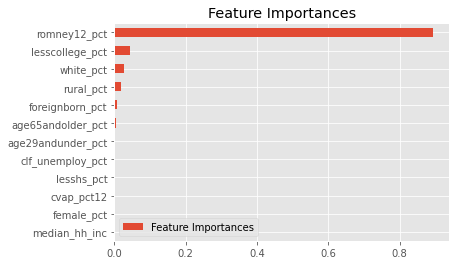

In [56]:
# Put into dataframe
coeff = pd.DataFrame(data = coeff, index=data3.columns, columns=["Feature Importances"])

# Plot these to look nice
coeff.sort_values(by='Feature Importances').plot(kind='barh')
plt.title("Feature Importances")
plt.savefig('../images/featureimportGB-data3.png', bbox_inches='tight', dpi=250)

In [64]:
# Check model
rmse, r_sq, coeff = modelers.kfold_scores(X_trainn, y_train, modelers.random_forest, 5)
rmse, r_sq, rmse.mean(), r_sq.mean()

(array([3.43634329, 3.22826461, 2.7597898 , 3.25515554, 2.9086371 ]),
 array([0.94746434, 0.95886575, 0.97091532, 0.95519993, 0.96413238]),
 3.117638067568278,
 0.9593155449808964)

In [65]:
d['Gradient Boosting'] = [rmse, r_sq]

In [53]:
# Save predictions
predictions = pd.DataFrame({'index_values': test_idx, 'trump_predict': y_hat, 'trump_true': y_test, 
              'clinton_predict': 100-y_hat, 'clinton_true': 100-y_test})
predictions.to_csv('../data/predictions_GB.csv')

## Plot performance of models

In [66]:
d

{'Linear Regression': [array([2.80943259, 3.14690697, 3.70960447, 3.4398307 , 3.17190092]),
  array([0.96717267, 0.95736271, 0.94642263, 0.95258994, 0.95706047])],
 'Random Forest': [array([3.01445098, 2.75007914, 3.05188876, 3.47236527, 3.00865806]),
  array([0.96839352, 0.96892879, 0.9580256 , 0.95047038, 0.9573927 ])],
 'Gradient Boosting': [array([3.43634329, 3.22826461, 2.7597898 , 3.25515554, 2.9086371 ]),
  array([0.94746434, 0.95886575, 0.97091532, 0.95519993, 0.96413238])]}

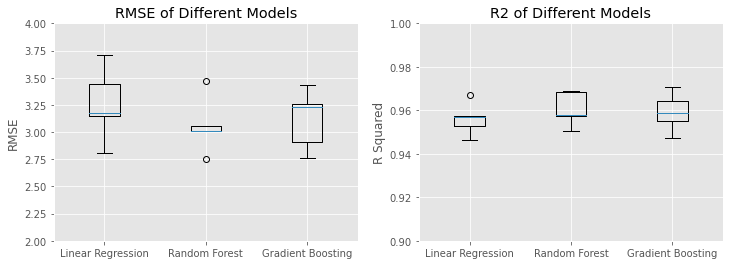

In [94]:
rmse = [d[i][0] for i in d]
r_sq = [d[i][1] for i in d]
labels = list(d.keys())

fig, axes = plt.subplots(1,2, figsize=(12,4))
ax = axes[0]
ax.boxplot(rmse, notch=0)
ax.set_xticklabels(labels)
ax.set_ylim(2,4)
ax.set_ylabel('RMSE')
ax.set_title("RMSE of Different Models")

ax = axes[1]
ax.boxplot(r_sq, notch=0)
ax.set_xticklabels(labels)
ax.set_ylim(0.9,1)
ax.set_ylabel('R Squared')
ax.set_title("R2 of Different Models")

plt.savefig('../images/model_performance.png', dpi=250)
